In [ ]:
# CAP 6619-002
# Movie Classifier
# Dr. Zhu
# Michael Cuomo

In [1]:
import os
import gc
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

import collections
import itertools
import pathlib
import re
import csv
import random

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import hamming_loss


In [2]:
EPOCH_NUM = 10
BATCH_SIZE = 128
# MOVIE_SUBSET = 474
# TESTING_SUBSET = 47
# MOVIE_SUBSET = 313
# TESTING_SUBSET = 31
TRAINING_SUBSET = 188
VALIDATION_SUBSET = 62
TESTING_SUBSET = 25
RANDOM_SEED = 35

In [3]:
directory = os.fsencode("./data/genres")
movie_names = []
for file in os.listdir(directory):
    movie_names.append(os.fsdecode(file))

shuffled_movies = movie_names.copy()
random.Random(RANDOM_SEED).shuffle(shuffled_movies)
print(movie_names[:20])
print(shuffled_movies[:20])

['10_Things_I_Hate_About_You.txt', '12.txt', '127_Hours.txt', '12_and_Holding.txt', '12_Monkeys.txt', '12_Years_a_Slave.txt', '1492_Conquest_of_Paradise.txt', '15_Minutes.txt', '17_Again.txt', '187.txt', '2001_A_Space_Odyssey.txt', '2012.txt', '28_Days_Later.txt', '30_Minutes_or_Less.txt', '44_Inch_Chest.txt', '48_Hrs.txt', '50-50.txt', '500_Days_of_Summer.txt', '8MM.txt', '9.txt']
['Bamboozled.txt', "Jacob's_Ladder.txt", 'Blind_Side,_The.txt', 'Terminator_Salvation.txt', '500_Days_of_Summer.txt', 'Pearl_Harbor.txt', 'Light_Sleeper.txt', 'Escape_From_New_York.txt', 'Ed_Wood.txt', 'Solaris.txt', 'Lincoln_Lawyer,_The.txt', 'Brazil.txt', 'True_Lies.txt', 'Burning_Annie.txt', 'Wolf_of_Wall_Street,_The.txt', 'My_Week_with_Marilyn.txt', 'Evil_Dead.txt', "Ocean's_Eleven.txt", 'Chronicle.txt', 'Disturbia.txt']


In [4]:
def plot_graphs(histories, legendNames, ylabel, title, metric):
  for history in histories:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend(list(itertools.chain.from_iterable(map(lambda x: [x, 'Validation ' + x], legendNames))))

In [2]:
def hamming_loss(y_true, y_pred):
    correct_pred = 0.0
    for x in range(y_true.shape[1]):
        if y_true[1][x] == (1.0 if y_pred[1][x] > 0.5 else 0.0):
            correct_pred += 1.0
    return correct_pred / y_true.shape[1]


In [5]:
def create_idf_encoder(vocab_size = 50000):
    encoder = tf.keras.layers.TextVectorization(max_tokens = vocab_size, standardize='lower_and_strip_punctuation', output_mode = 'tf_idf')
    dataset = tf.data.TextLineDataset(filenames = list(map(lambda x: f"./data/scripts/{x}", movie_names)))
    encoder.adapt(dataset.batch(1024))
    return encoder

def write_idf_encoder(encoder, filename, vocab_size = 50000):
    pickle.dump({'config': encoder.get_config(),
             'weights': encoder.get_weights()}
            , open(f"./data/vocabs/{filename}_idf_vocab_{vocab_size}.pkl", "wb"))

In [4]:
def create_encoder(vocab_size = 50000):
    encoder = tf.keras.layers.TextVectorization(max_tokens = vocab_size, standardize='lower_and_strip_punctuation')
    dataset = tf.data.TextLineDataset(filenames = list(map(lambda x: f"./data/scripts/{x}", movie_names)))
    encoder.adapt(dataset.batch(1024))
    return encoder

def writeEncoder(encoder, filename, vocab_size = 50000):
    with open(f"./data/vocabs/{filename}_{vocab_size}.txt", "w", encoding = 'utf-8') as f:
        wr = csv.writer(f)
        wr.writerow(encoder.get_vocabulary())

In [5]:
def get_existing_encoder(encoder_type = "", vocab_size = 50000):
    if vocab_size != 50000 and vocab_size != 10000 and vocab_size != 5000:
        raise ValueError("Vocab of that size does not exist")
    encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size, standardize='lower_and_strip_punctuation')
    f = open(f"./data/vocabs/vocab{encoder_type}_{vocab_size}.txt", "r", errors = "ignore", encoding = "utf-8")
    vocab = f.read()
    f.close()

    encoder.set_vocabulary(vocab.split(","))
    return encoder

def get_existing_idf_encoder(encoder_type = "", vocab_size = 5000):
    if vocab_size != 50000 and vocab_size != 10000 and vocab_size != 5000:
        raise ValueError("Vocab of that size does not exist")
    from_disk = pickle.load(open(f"./data/vocabs/{encoder_type}_idf_vocab_{vocab_size}.pkl", "rb"))
    encoder = tf.keras.layers.TextVectorization.from_config(from_disk["config"])
    encoder.set_weights(from_disk["weights"])

    return encoder

In [6]:
def createLstmModel(encoder = get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5):
    model = tf.keras.models.Sequential()
    model.add(encoder)
    model.add(tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()) + 1, output_dim = 64, mask_zero = True))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 64, dropout = dropout)))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(27, activation='sigmoid'))
    return model

In [7]:
def createGruModel(encoder = get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5):
    model = tf.keras.models.Sequential()
    model.add(encoder)
    model.add(tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()) + 1, output_dim = 64, mask_zero = True))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units = 64, dropout = dropout)))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(27, activation='sigmoid'))
    return model

In [8]:
def flatValue(x):
    return tf.constant([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

def createDummyModel():
    input = layers.Input(shape = (), dtype = tf.string)
    output = layers.Lambda(flatValue, output_shape = (27,))(input)
    return models.Model(input, output)

In [10]:
def trainSuccintGenerator():
    for movie in shuffled_movies[:TRAINING_SUBSET]:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        random.Random(RANDOM_SEED).shuffle(script_lines)
        g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        genres = g.read().split(",")
        g.close()
        for line in script_lines:
            yield line, tf.stack(genres)
        del s
        del script_lines
        del g
        del genres
        gc.collect()

def validationSuccintGenerator():
    for movie in shuffled_movies[TRAINING_SUBSET:TRAINING_SUBSET + VALIDATION_SUBSET]:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        random.Random(RANDOM_SEED).shuffle(script_lines)
        g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        genres = g.read().split(",")
        g.close()
        for line in script_lines:
            yield line, tf.stack(genres)
        del s
        del script_lines
        del g
        del genres
        gc.collect()

def testSuccintGenerator():
    for movie in shuffled_movies[-TESTING_SUBSET:]:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        genres = g.read().split(",")
        g.close()
        for line in script_lines:
            yield line, tf.stack(genres)
        del s
        del script_lines
        del g
        del genres
        gc.collect()

def getSuccinctTrainDataset():
    dataset = tf.data.Dataset.from_generator(trainSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (27,), dtype = tf.float32)))
    return dataset

def getSuccinctValidationDataset():
    dataset = tf.data.Dataset.from_generator(validationSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (27,), dtype = tf.float32)))
    return dataset

def getSuccinctTestDataset():
    dataset = tf.data.Dataset.from_generator(testSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (27,), dtype = tf.float32)))
    return dataset


In [8]:
# def trainSuccintGenerator():
#     num_movie_subset = len(shuffled_movies)
#     if MOVIE_SUBSET > 0:
#         num_movie_subset = MOVIE_SUBSET
#     # movie = movie_names[0]
#     # s = open(f".\\data\\scripts\\{movie}", "r")
#     # script_lines = s.read().split("\n")
#     # s.close()
#     # random.Random(42).shuffle(script_lines)
#     # script_lines = script_lines[:int(len(script_lines) * 0.75) + 1]
#     # k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
#     # keywords = k.read().split(",")
#     # k.close()
#     # for line in script_lines:
#     #     yield line, keywords
#     for movie in shuffled_movies[:num_movie_subset]:
#         s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
#         script_lines = s.read().split("\n")
#         s.close()
#         random.Random(42).shuffle(script_lines)
#         script_lines = script_lines[:int(len(script_lines) * 0.75) + 1]
#         # genres = numpy.loadtxt(f"./data/vectorized_genres/{movie}", delimiter = ",")
#         # for line in script_lines:
#         #     yield line, genres
#         g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
#         genres = g.read().split(",")
#         g.close()
#         for line in script_lines:
#             yield line, tf.stack(genres)
#         del s
#         del script_lines
#         del g
#         del genres
#         gc.collect()

# def validationSuccintGenerator():
#     num_movie_subset = len(shuffled_movies)
#     if MOVIE_SUBSET > 0:
#          num_movie_subset = MOVIE_SUBSET
#     # movie = movie_names[0]
#     # s = open(f".\\data\\scripts\\{movie}", "r")
#     # script_lines = s.read().split("\n")
#     # s.close()
#     # random.Random(42).shuffle(script_lines)
#     # script_lines = script_lines[-(int(len(script_lines) * 0.75) + 1):]
#     # k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
#     # keywords = k.read().split(",")
#     # k.close()
#     # for line in script_lines:
#     #     yield line, keywords
#     for movie in shuffled_movies[:num_movie_subset]:
#         s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
#         script_lines = s.read().split("\n")
#         s.close()
#         random.Random(42).shuffle(script_lines)
#         script_lines = script_lines[-(int(len(script_lines) * 0.75) + 1):]
#         # genres = numpy.loadtxt(f"./data/vectorized_genres/{movie}", delimiter = ",")
#         # for line in script_lines:
#         #     yield line, genres
#         g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
#         genres = g.read().split(",")
#         g.close()
#         for line in script_lines:
#             yield line, tf.stack(genres)
#         del s
#         del script_lines
#         del g
#         del genres
#         gc.collect()

# def testSuccintGenerator():
#     num_movie_subset = TESTING_SUBSET
#     # if MOVIE_SUBSET > 0:
#     #     num_movie_subset = len(shuffled_movies) - MOVIE_SUBSET
#         # num_movie_subset = 5
#     for movie in shuffled_movies[-num_movie_subset:]:
#         s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
#         script_lines = s.read().split("\n")
#         s.close()
#         g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
#         genres = g.read().split(",")
#         g.close()
#         for line in script_lines:
#             yield line, tf.stack(genres)
#         del s
#         del script_lines
#         del g
#         del genres
#         gc.collect()

# def getSuccinctTrainDataset():
#     dataset = tf.data.Dataset.from_generator(trainSuccintGenerator, output_signature = (
#         tf.TensorSpec(shape = (), dtype = tf.string),
#         tf.TensorSpec(shape = (27,), dtype = tf.float32)))
#     return dataset

# def getSuccinctValidationDataset():
#     dataset = tf.data.Dataset.from_generator(validationSuccintGenerator, output_signature = (
#         tf.TensorSpec(shape = (), dtype = tf.string),
#         tf.TensorSpec(shape = (27,), dtype = tf.float32)))
#     return dataset

# def getSuccinctTestDataset():
#     dataset = tf.data.Dataset.from_generator(testSuccintGenerator, output_signature = (
#         tf.TensorSpec(shape = (), dtype = tf.string),
#         tf.TensorSpec(shape = (27,), dtype = tf.float32)))
#     return dataset


In [11]:
train = getSuccinctTrainDataset()
validation = getSuccinctValidationDataset()
test = getSuccinctTestDataset()
train = train.batch(BATCH_SIZE)
validation = validation.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [ ]:
# TF Encoder not working

# lstm_model = createLstmModel(get_existing_idf_encoder(encoder_type = "pickle", vocab_size = 10000), dropout = 0.5)
# lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
# gru_model = createGruModel(get_existing_idf_encoder(encoder_type = "pickle", vocab_size = 10000), dropout = 0.5)
# gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
# dummy_model = createDummyModel()
# dummy_model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], run_eagerly=False)

In [12]:
lstm_model = createLstmModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5)
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
gru_model = createGruModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5)
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
dummy_model = createDummyModel()
dummy_model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], run_eagerly=False)

In [9]:
# lstm_model_50 = createLstmModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5)
# lstm_model_50.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
# gru_model_50 = createGruModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5)
# gru_model_50.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
# dummy_model_50 = createDummyModel()
# dummy_model_50.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], run_eagerly=False)

In [13]:
def getModelSaveCallback(model_name, training_number):
    checkpoint_path = f"./models/{model_name}/training_{training_number}" + "/cp-{epoch:04d}.ckpt"
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1, 
        save_weights_only=True)

def getHistorySaveCallback(model_name, training_number):
    filepath = f"./models/{model_name}/training_{training_number}/log_history.csv"
    return tf.keras.callbacks.CSVLogger(filepath, separator=",", append=True)

In [17]:
# latest_checkpoint = tf.train.latest_checkpoint("./models/mk5_lstm_half_data/training_2/")
# lstm_model.load_weights(latest_checkpoint)
# lstm_model.build(())

In [14]:
lstm_model_name = "mk7_lstm_separate_validation"
gru_model_name = "mk7_gru_separate_validation"
dummy_model_name = "mk7_dummy_separate_validation"
lstm_training_number = 1
gru_training_number = 1
dummy_training_number = 1


lstm_callback = getModelSaveCallback(lstm_model_name, lstm_training_number)
lstm_history_callback = getHistorySaveCallback(lstm_model_name, lstm_training_number)
gru_callback = getModelSaveCallback(gru_model_name, gru_training_number)
gru_history_callback = getHistorySaveCallback(gru_model_name, gru_training_number)
dummy_callback = getModelSaveCallback(dummy_model_name, dummy_training_number)
dummy_history_callback = getHistorySaveCallback(dummy_model_name, dummy_training_number)


In [23]:
# gru_model_name = "mk6_gru_quarter_data"
# gru_model = createGruModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000), dropout = 0.5)
# gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
# gru_callback = getModelSaveCallback(gru_model_name, 0)
# gru_history_callback = getHistorySaveCallback(gru_model_name, 0)

In [15]:
lstm_history = lstm_model.fit(train,
                                epochs = 10,
                                validation_data=validation,
                                callbacks=[lstm_callback, lstm_history_callback],
                                validation_steps=30)

Epoch 1/10
   6773/Unknown - 216s 31ms/step - loss: 0.2341 - binary_accuracy: 0.9072
Epoch 1: saving model to ./models/mk7_lstm_separate_validation/training_1\cp-0001.ckpt
6774/6774 [==============================] - 218s 31ms/step - loss: 0.2341 - binary_accuracy: 0.9072 - val_loss: 0.3263 - val_binary_accuracy: 0.9259
Epoch 2/10
6773/6774 [============================>.] - ETA: 0s - loss: 0.2165 - binary_accuracy: 0.9121
Epoch 2: saving model to ./models/mk7_lstm_separate_validation/training_1\cp-0002.ckpt
6774/6774 [==============================] - 243s 36ms/step - loss: 0.2165 - binary_accuracy: 0.9121 - val_loss: 0.3249 - val_binary_accuracy: 0.9221
Epoch 3/10
6773/6774 [============================>.] - ETA: 0s - loss: 0.2065 - binary_accuracy: 0.9172
Epoch 3: saving model to ./models/mk7_lstm_separate_validation/training_1\cp-0003.ckpt
6774/6774 [==============================] - 257s 38ms/step - loss: 0.2065 - binary_accuracy: 0.9172 - val_loss: 0.3432 - val_binary_accuracy: 0

In [16]:
with open(f'./models/{lstm_model_name}/training_{lstm_training_number}/pickle_history', 'wb') as file_pi:
    pickle.dump(lstm_history.history, file_pi)

with open(f'./models/{lstm_model_name}/training_{lstm_training_number}/pickle_model', 'wb') as file_pi:
    pickle.dump(lstm_history.model, file_pi)

In [17]:
gru_history = gru_model.fit(train,
                            epochs = EPOCH_NUM,
                            validation_data=validation,
                            callbacks=[gru_callback, gru_history_callback],
                            validation_steps=30)

Epoch 1/10


   6773/Unknown - 264s 38ms/step - loss: 0.2271 - binary_accuracy: 0.9100
Epoch 1: saving model to ./models/mk7_gru_separate_validation/training_1\cp-0001.ckpt
6774/6774 [==============================] - 266s 39ms/step - loss: 0.2271 - binary_accuracy: 0.9100 - val_loss: 0.3373 - val_binary_accuracy: 0.9168
Epoch 2/10
6773/6774 [============================>.] - ETA: 0s - loss: 0.2022 - binary_accuracy: 0.9173
Epoch 2: saving model to ./models/mk7_gru_separate_validation/training_1\cp-0002.ckpt
6774/6774 [==============================] - 263s 39ms/step - loss: 0.2022 - binary_accuracy: 0.9173 - val_loss: 0.3598 - val_binary_accuracy: 0.9204
Epoch 3/10
6773/6774 [============================>.] - ETA: 0s - loss: 0.1920 - binary_accuracy: 0.9217
Epoch 3: saving model to ./models/mk7_gru_separate_validation/training_1\cp-0003.ckpt
6774/6774 [==============================] - 260s 38ms/step - loss: 0.1919 - binary_accuracy: 0.9217 - val_loss: 0.3554 - val_binary_accuracy: 0.8992
Epoch 4/

In [18]:
with open(f'./models/{gru_model_name}/training_{gru_training_number}/pickle_history', 'wb') as file_pi:
    pickle.dump(gru_history.history, file_pi)

with open(f'./models/{gru_model_name}/training_{gru_training_number}/pickle_model', 'wb') as file_pi:
    pickle.dump(gru_history.model, file_pi)

In [19]:
dummy_history = dummy_model.fit(train,
                                epochs = EPOCH_NUM,
                                validation_data = validation,
                                callbacks=[dummy_callback, dummy_history_callback],
                                validation_steps = 30)

Epoch 1/10
     38/Unknown - 1s 18ms/step - loss: 1.1426 - binary_accuracy: 0.9259

   6774/Unknown - 142s 21ms/step - loss: 1.4954 - binary_accuracy: 0.9029
Epoch 1: saving model to ./models/mk7_dummy_separate_validation/training_1\cp-0001.ckpt
6774/6774 [==============================] - 143s 21ms/step - loss: 1.4954 - binary_accuracy: 0.9029 - val_loss: 1.1392 - val_binary_accuracy: 0.9259
Epoch 2/10
6774/6774 [==============================] - ETA: 0s - loss: 1.4954 - binary_accuracy: 0.9029
Epoch 2: saving model to ./models/mk7_dummy_separate_validation/training_1\cp-0002.ckpt
6774/6774 [==============================] - 147s 22ms/step - loss: 1.4954 - binary_accuracy: 0.9029 - val_loss: 1.1392 - val_binary_accuracy: 0.9259
Epoch 3/10
6774/6774 [==============================] - ETA: 0s - loss: 1.4954 - binary_accuracy: 0.9029
Epoch 3: saving model to ./models/mk7_dummy_separate_validation/training_1\cp-0003.ckpt
6774/6774 [==============================] - 142s 21ms/step - loss: 1.4954 - binary_accuracy: 0.9029 - val_loss: 1.1392 - val_binary_accuracy: 0.9259
Ep

In [20]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(test)
gru_test_loss, gru_test_acc = gru_model.evaluate(test)
dummy_test_loss, dummy_test_acc = dummy_model.evaluate(test)

print('LSTM Test Loss:', lstm_test_loss)
print('LSTM Test Accuracy:', lstm_test_acc)
print('GRU Test Loss:', gru_test_loss)
print('GRU Test Accuracy:', gru_test_acc)
print('Dummy Test Loss:', dummy_test_loss)
print('Dummy Test Accuracy:', dummy_test_acc)

844/844 [==============================] - 22s 26ms/step - loss: 1.4415 - binary_accuracy: 0.9064
LSTM Test Loss: 0.3836827278137207
LSTM Test Accuracy: 0.8989611268043518
GRU Test Loss: 0.3725731670856476
GRU Test Accuracy: 0.9003735780715942
Dummy Test Loss: 1.4414560794830322
Dummy Test Accuracy: 0.9064418077468872


In [21]:
model_test_values = { "LSTM": { "Test Loss": lstm_test_loss, "Test Accuracy": lstm_test_acc }, "GRU": { "Test Loss": gru_test_loss, "Test Accuracy": gru_test_acc }, "Dummy": { "Test Loss": dummy_test_loss, "Test Accuracy": dummy_test_acc } }

if not os.path.exists("./models/mk7_test_data"):
    os.makedirs("./models/mk7_test_data")

with open(f'./models/mk7_test_data/test_data', 'wb') as file_pi:
    pickle.dump(model_test_values, file_pi)


In [30]:
with open(f'./models/mk6_test_data/test_data', 'rb') as file_pi:
    test_data = pickle.load(file_pi)

print(test_data)

{'lstm': {'test_loss': 0.30938613414764404, 'test_acc': 0.9075561165809631}, 'gru': {'test_loss': 0.29427117109298706, 'test_acc': 0.9094348549842834}, 'dummy': {'test_loss': 1.356253981590271, 'test_acc': 0.9119824171066284}}


C:\Users\mcuom\AppData\Local\Temp\ipykernel_20592\51319224.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


(0.0, 1.5610310643911363)

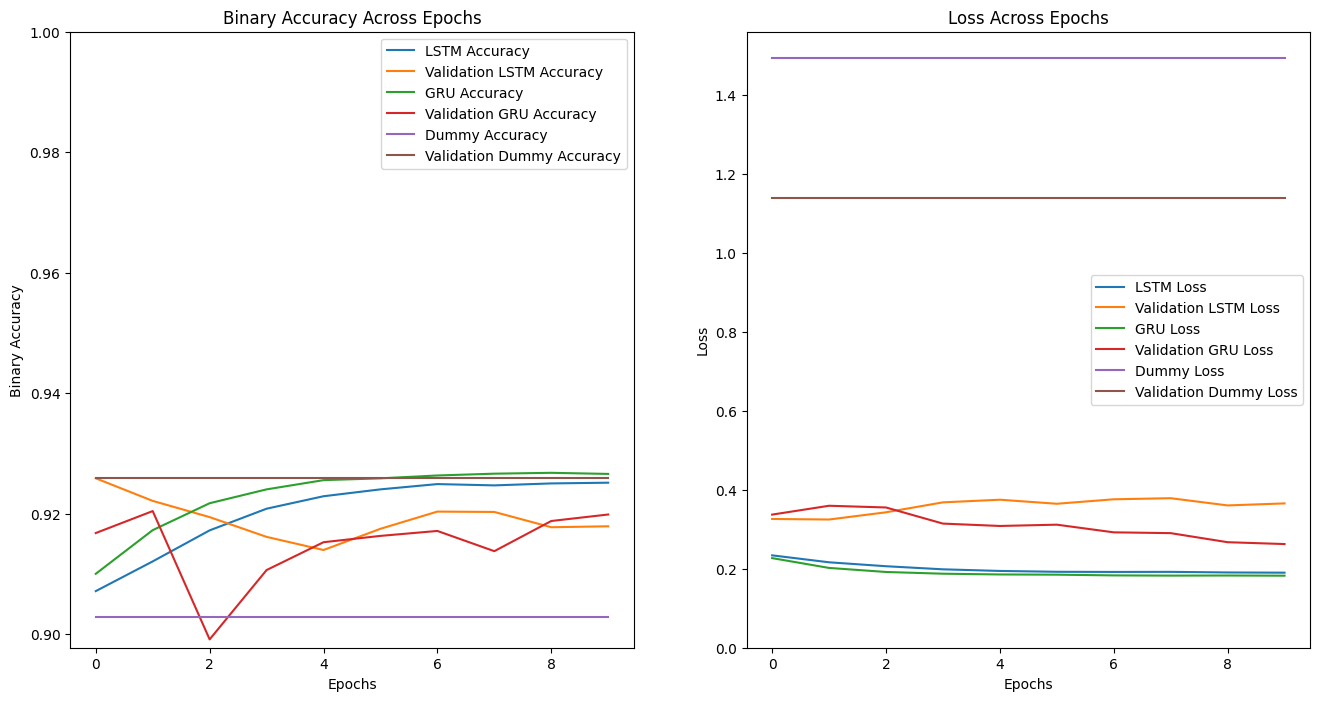

In [22]:
plt.figure(figsize=(16, 8))
plt.title("Train and Validation Accuracy and Loss Model Comparison")
plt.subplot(1, 2, 1)
plot_graphs([lstm_history, gru_history, dummy_history], ["LSTM Accuracy", "GRU Accuracy", "Dummy Accuracy"], "Binary Accuracy", "Binary Accuracy Across Epochs", 'binary_accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs([lstm_history, gru_history, dummy_history], ["LSTM Loss", "GRU Loss", "Dummy Loss"], "Loss", "Loss Across Epochs", 'loss')
plt.ylim(0, None)

[Text(0, 0, '0.383683'), Text(0, 0, '0.372573'), Text(0, 0, '1.44146')]

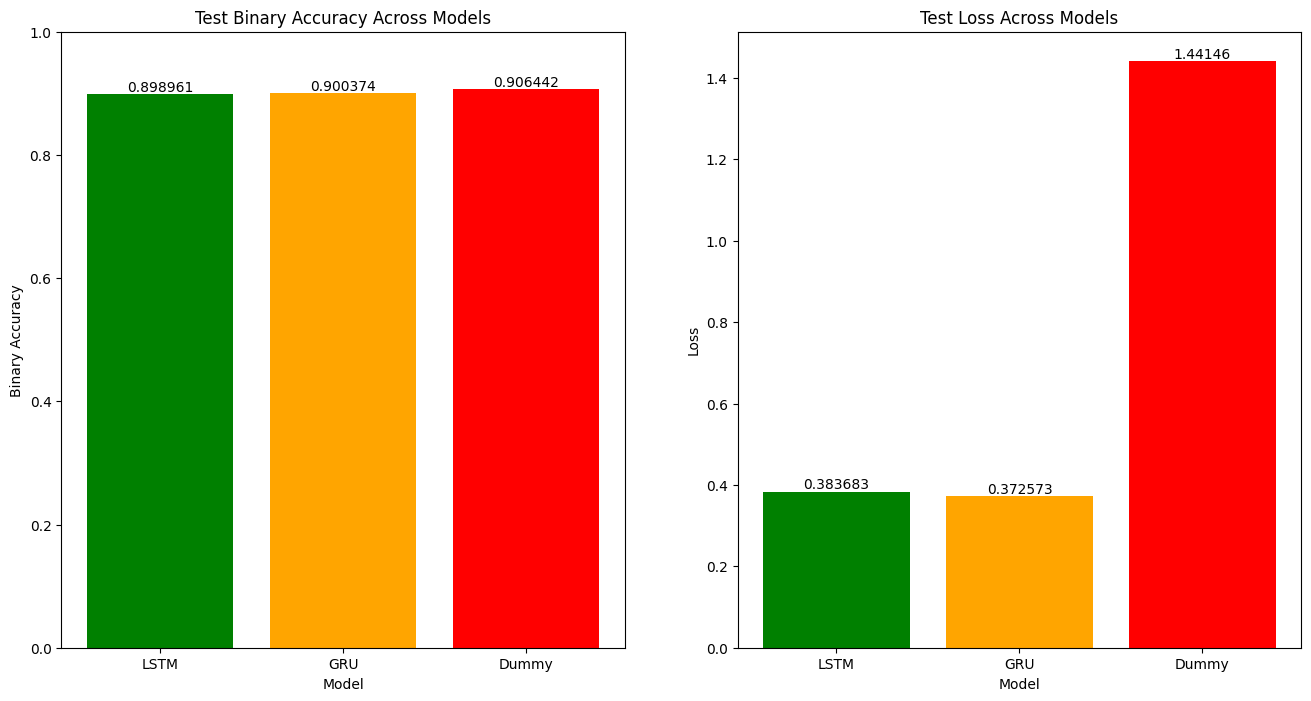

In [23]:
model_names = ["LSTM", "GRU", "Dummy"]
colors = ["green", "orange", "red"]

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Test Binary Accuracy Across Models")
plt.xlabel("Model")
plt.ylabel("Binary Accuracy")
test_binary_accuracy_bar = plt.bar(model_names, [lstm_test_acc, gru_test_acc, dummy_test_acc], color = colors)
plt.bar_label(test_binary_accuracy_bar)
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plt.title("Test Loss Across Models")
plt.xlabel("Model")
plt.ylabel("Loss")
test_loss_bar = plt.bar(model_names, [lstm_test_loss, gru_test_loss, dummy_test_loss], color = colors)
plt.bar_label(test_loss_bar)

In [53]:
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_17 (Tex  (None, None)              0         
 tVectorization)                                                 
                                                                 
 embedding_9 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_9 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 27)                1755      
                                                                 
Total params: 716059 (2.73 MB)
Trainable params: 71605

In [54]:
gru_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_18 (Tex  (None, None)              0         
 tVectorization)                                                 
                                                                 
 embedding_10 (Embedding)    (None, None, 64)          640000    
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               49920     
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 27)                1755      
                                                                 
Total params: 699931 (2.67 MB)
Trainable params: 6999

In [84]:
dummy_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None,)]                 0         
                                                                 
 lambda_14 (Lambda)          (27,)                     0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


In [129]:
checkpoint_path = "./models/mk3_binary_crossentropy/training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [137]:
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
history = model.fit(train,
                    epochs = 1,
                    validation_data=test,
                    callbacks=[cp_callback],
                    validation_steps=30)


Tensor("strided_slice_2:0", shape=(), dtype=float32)
Tensor("strided_slice_4:0", shape=(), dtype=float32)
Tensor("strided_slice_2:0", shape=(), dtype=float32)
Tensor("strided_slice_4:0", shape=(), dtype=float32)
   1214/Unknown - 123s 88ms/step - loss: 0.2740 - binary_accuracy: 0.8958 - HAMMING_LOSS: 0.8976

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 27)                1755      
                                                                 
Total params: 396059 (1.51 MB)
Trainable params: 396059 

In [39]:
model = createSuccinctOutputVectorModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 5000))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'], run_eagerly=False)
model.load_weights("./models/mk2_binary_crossentropy/training_1/cp-0002.ckpt")

In [15]:
train = getSuccinctTrainDataset()
test = next(iter(train))

In [44]:
test2 = next(iter(test))

In [18]:
input, output = test

In [45]:
print(test2)

(<tf.Tensor: shape=(128,), dtype=string, numpy=
array([b'PATRICK', b"-- I stayed with her.  I wasn't in jail,",
       b'She turns to Kat.', b"I don't understand the allure of",
       b'She turns to face him with a countenance more in sorrow than',
       b'Do you think you could give me a ride',
       b'With the teeth of your zipper?', b'the hallway.', b'KAT',
       b'PATRICK', b"Because you're making decisions for me.", b'PATRICK',
       b'line of kids below.', b'MICHAEL', b'KAT',
       b"I didn't care about the money.",
       b'He wipes a smear of blue paint away from her lips,  as he',
       b'from the water fountain.', b'RIDER',
       b'I was kidding. People actually live', b'give it a day.',
       b'What can I get you?', b'PATRICK', b'PATRICK',
       b'(matter of fact)', b'count as a date.', b'(continuing)',
       b"you won't be there.", b'thing on Saturday?',
       b'moped. Kat has to SLAM the brakes to keep from hitting him',
       b'PATRICK', b'KAT', b'flash of sk

In [49]:
test_output = model.predict(test2[0])

4/4 [==============================] - 0s 8ms/step


In [58]:
test_output = model.predict(["An '89 Mustang bursts like a shot over a rise in the highway.",
"It's got a rusted two-tone paint job, Maryland plates, and",
"bald tires that scream as it peels off an exit and into the",
"EXT. SUBURBS - DAY",
"The car fast approaches a stop sign, dangerously blows through",
"the intersection.",
"INT. MUSTANG - DAY - MOVING",
"We don't see the DRIVER, only the redlining RPMs, Vans slip-",
"ons working the pedals, wristwatch being checked. The wheel",
"cranks right as the car turns onto a -",
"One way street. A minivan flies right at us. The Mustang"])

1/1 [==============================] - 0s 61ms/step


In [59]:
print(test_output)

[[3.14859718e-01 5.42348444e-01 1.68708369e-01 2.63345540e-01
  3.03521246e-01 1.14595674e-01 2.16133639e-01 1.88599646e-01
  9.16576013e-02 2.49108329e-01 2.63186067e-01 1.29022479e-01
  4.89824861e-02 1.03912704e-01 1.78554095e-02 1.46104038e-01
  2.64835116e-02 1.33981064e-01 9.75284427e-02 6.29631802e-02
  3.26888170e-03 3.08371820e-02 8.45037997e-02 1.72019227e-05
  2.15044431e-02 6.45477027e-02 6.08475057e-05]
 [3.96176398e-01 6.07196689e-01 2.10735574e-01 2.27306649e-01
  2.10784093e-01 1.08515538e-01 9.71222743e-02 9.91916656e-02
  7.17160106e-02 1.44589543e-01 1.60658166e-01 8.13159272e-02
  2.72275396e-02 4.14533280e-02 4.34602471e-03 8.29793587e-02
  1.17788035e-02 7.76691511e-02 3.85149345e-02 3.02444864e-02
  2.79898581e-04 2.66844295e-02 3.26348506e-02 1.03989362e-06
  1.15185147e-02 3.97424698e-02 8.01345413e-06]
 [3.58642548e-01 5.66070676e-01 2.04575703e-01 2.38853574e-01
  2.54501760e-01 1.17300957e-01 1.55803606e-01 1.41407698e-01
  8.75649601e-02 1.99323028e-01 2.05

In [63]:
avg_output = numpy.nanmean(test_output, axis = 0)
print(avg_output)

[3.38747770e-01 5.70392907e-01 1.88762441e-01 2.41290316e-01
 2.60716408e-01 1.20401733e-01 1.64215475e-01 1.55770719e-01
 9.19817463e-02 2.14215294e-01 2.21295536e-01 1.16930276e-01
 4.33513671e-02 8.26575682e-02 1.21150166e-02 1.19710110e-01
 2.10424736e-02 1.15307644e-01 7.43279755e-02 5.23184650e-02
 1.51890062e-03 3.41575406e-02 6.61721230e-02 7.02847865e-06
 2.03241836e-02 5.82738183e-02 3.48779795e-05]


In [64]:
# mapped_output = list(map(lambda s: list(map(lambda x: 1 if x > 0.5 else 0, s)), test_output))
# print(mapped_output)

mapped_output = list(map(lambda x: 1 if x > 0.5 else 0, avg_output))
print(mapped_output)


[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [20]:
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


  17169/Unknown - 572s 33ms/step - loss: 0.2901 - binary_accuracy: 0.8939

TypeError: plot_graphs() missing 2 required positional arguments: 'ylabel' and 'metric'

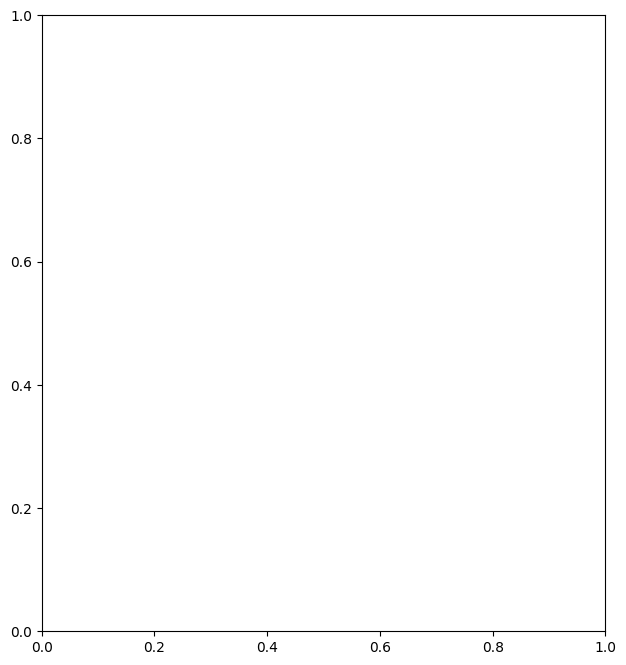

In [110]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [ ]:
def succintGenerator(seed = 42, train_split = 0.75, is_train = True):
    # for movie in movie_names:
    #     s = open(f".\\data\\scripts\\{movie}", "r")
    #     script_lines = random.Random(seed).shuffle(s.read().split("\n"))
    #     s.close()
    #     if is_train:
    #         script_lines = script_lines[:int(len(script_lines) * train_split) + 1]
    #     else:
    #         script_lines = script_lines[-(int(len(script_lines) * train_split) + 1):]
    #     k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    #     keywords = k.read().split(",")
    #     k.close()
    #     for line in script_lines:
    #         yield line, keywords
    movie = movie_names[0]
    s = open(f"./data/scripts/{movie}", "r")
    script_lines = random.Random(seed).shuffle(s.read().split("\n"))
    s.close()
    if is_train:
        script_lines = script_lines[:int(len(script_lines) * train_split) + 1]
    else:
        script_lines = script_lines[-(int(len(script_lines) * train_split) + 1):]
    k = open(f"./data/vectorized_keywords_succinct/{movie}", "r")
    keywords = k.read().split(",")
    k.close()
    for line in script_lines:
        yield line, keywords

In [10]:
latest_checkpoint_lstm = tf.train.latest_checkpoint("./models/mk6_lstm_third_data/training_0/")
lstm_model.load_weights(latest_checkpoint_lstm)
lstm_model.build(())

latest_checkpoint_lstm_50 = tf.train.latest_checkpoint("./models/mk5_lstm_half_data/training_2/")
lstm_model_50.load_weights(latest_checkpoint_lstm_50)
lstm_model_50.build(())

latest_checkpoint_gru = tf.train.latest_checkpoint("./models/mk6_gru_third_data/training_0/")
gru_model.load_weights(latest_checkpoint_gru)
gru_model.build(())

latest_checkpoint_gru_50 = tf.train.latest_checkpoint("./models/mk5_gru_half_data/training_0/")
gru_model_50.load_weights(latest_checkpoint_gru_50)
gru_model_50.build(())

In [19]:
coco_lines = ["EXT. MARIGOLD PATH - DUSK",
"A path of marigold petals leads up to an altar lovingly",
"arranged in a humble cemetery. An old woman lights a candle",
"as the smoke of burning copal wood dances lyrically upward...",
"CARD: DISNEY PRESENTS",
"CARD: A PIXAR ANIMATION STUDIOS FILM",
"The smoke lifts up toward lines of papel picado - cut paper",
"banners -- that sway gently in the breeze.",
"PAPEL PICADO CARD: \"COCO\"",
"MIGUEL (V.O.)"]

In [20]:
lstm_33_predict = lstm_model.predict(coco_lines)
threshold = list(map(lambda x: list(map(lambda y: 1 if y >= 0.5 else 0, x)), lstm_33_predict))
print(threshold)

1/1 [==============================] - 0s 31ms/step
[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [22]:
lstm_50_predict = lstm_model_50.predict(coco_lines)
threshold = list(map(lambda x: list(map(lambda y: 1 if y >= 0.5 else 0, x)), lstm_50_predict))
print(threshold)

1/1 [==============================] - 0s 34ms/step
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [23]:
gru_33_predict = gru_model.predict(coco_lines)
threshold = list(map(lambda x: list(map(lambda y: 1 if y >= 0.5 else 0, x)), gru_33_predict))
print(threshold)

1/1 [==============================] - 2s 2s/step
[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [24]:
gru_50_predict = gru_model_50.predict(coco_lines)
threshold = list(map(lambda x: list(map(lambda y: 1 if y >= 0.5 else 0, x)), gru_50_predict))
print(threshold)

1/1 [==============================] - 3s 3s/step
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
